## The best we can do with trees
This is the upper boundary of what we can achieve with trees, using all features


In [48]:
%matplotlib inline

import pandas as pd
import numpy as np
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn import cross_validation, grid_search
from sklearn.cross_validation import cross_val_score 
from modeling_funcs import *
from IPython.display import display
import seaborn as sns

sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (10.0, 10.0)


In [49]:
vectorized_data = pd.read_csv('../all_data_vectorized.csv', sep='|', index_col=0)
slope = pd.read_csv('../all_slope.csv', sep = '|', index_col=0)
all_feature_metadata = pickle.load( open('../all_feature_metadata.pickle', 'rb') )

everybody = vectorized_data.join(slope)


In [50]:
q = np.percentile(everybody.ALSFRS_slope, range(0,100,10))
everybody.loc[:, 'ALSFRS_bin'] = np.digitize(everybody.ALSFRS_slope, q)
display(everybody[['ALSFRS_slope','ALSFRS_bin']].describe())

,ALSFRS_slope,ALSFRS_bin
count,2424.000000,2424.000000
mean,-0.730786,5.503713
std,0.627481,2.876174
min,-4.345238,1.000000
25%,-1.086310,3.000000
50%,-0.620748,6.000000
75%,-0.274234,8.000000
max,1.207011,10.000000


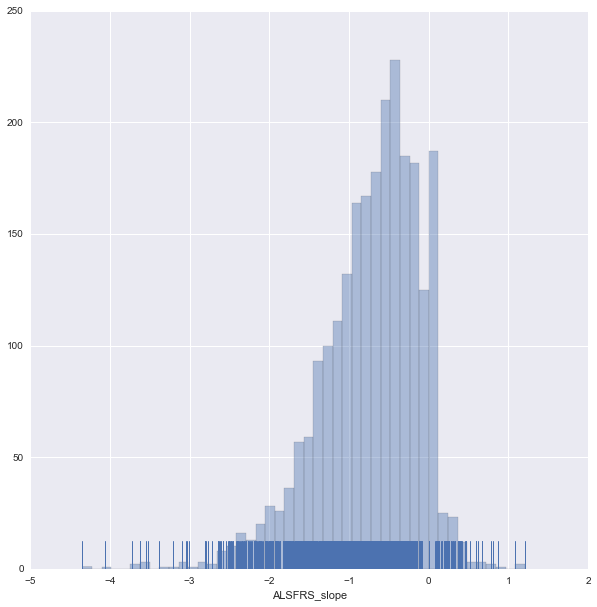

In [51]:
sns.distplot(everybody.ALSFRS_slope, rug=True, kde=False);

In [52]:
from sklearn import tree

X = everybody.drop(['ALSFRS_slope','ALSFRS_bin'], 1)
y = everybody.ALSFRS_slope

clf = grid_search.GridSearchCV(tree.DecisionTreeRegressor(), 
                               {'min_samples_split':range(250,270,5), 'min_samples_leaf': range(50,70,5)})
print np.sqrt(-1.0 * cross_val_score(clf, X, y, scoring="mean_squared_error").mean())

0.595149952765


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=65, min_samples_split=250,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')
train mse 0.569172343882
test mse 0.597130591092


,prediction,actual,SE
SubjectID,,,
468194,-0.618905,-0.618644,6.834310e-08
409379,-0.771234,-0.774242,9.052567e-06
630294,-0.824607,-0.827664,9.348323e-06


,prediction,actual,SE
SubjectID,,,
880451,-0.771234,-2.516487,3.045909
364548,-1.046493,-2.804374,3.090144
491548,-0.771234,-2.607143,3.370563
15154,-0.618905,-2.628601,4.038875
596259,-0.824607,1.207011,4.127470
414305,-0.903134,-3.030013,4.523611
809464,-1.168859,1.086310,5.085787
549126,-1.168859,-3.621032,6.013149
505515,-0.903134,-3.553349,7.023637


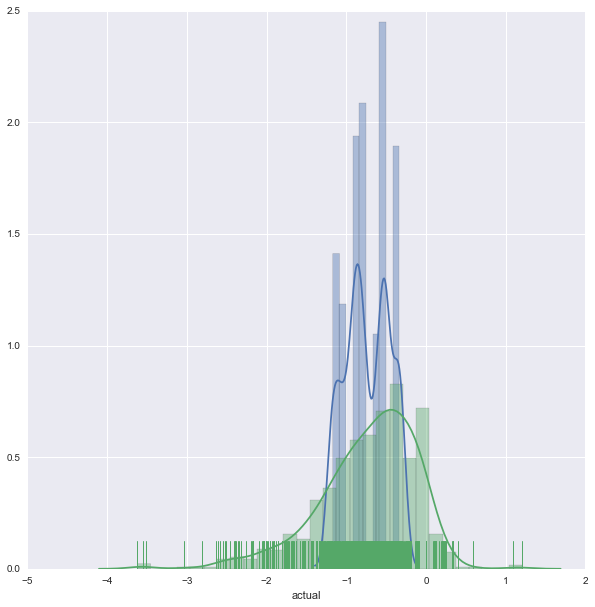

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

def pred_vs_actual(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=0)

    clf.fit(X_train, y_train)
    print clf.best_estimator_
    print "train mse", np.sqrt(mean_squared_error(y_train, clf.predict(X_train)))    
    res = X_test.apply(lambda s: pd.Series({'prediction': clf.predict(s)[0]}) , axis=1)
    res.loc[:, 'actual'] = y_test
    res.loc[:, 'SE'] = res.apply(lambda s: (s['prediction'] - s['actual'])**2 , axis=1)
    print "test mse", np.sqrt(mean_squared_error(res.actual, res.prediction))
    display(res.sort(['SE']).head(3))
    display(res.sort(['SE']).tail(10))
    sns.distplot(res.prediction);
    sns.distplot(res.actual, rug=True);
    return res
    
res = pred_vs_actual(clf, X, y)
print

In [54]:
from sklearn.externals.six import StringIO
with open("../tree.dot", 'w') as f:
    f = tree.export_graphviz(clf.best_estimator_, feature_names = X.columns, out_file=f)

In [55]:
from sklearn.ensemble import RandomForestRegressor
clf = grid_search.GridSearchCV(RandomForestRegressor(min_samples_leaf=60, min_samples_split=260, random_state=0), 
                               {'min_samples_leaf': range(60,61,10), 'n_estimators': [1000]})
print np.sqrt(-1.0 * cross_val_score(clf, X, y, scoring="mean_squared_error").mean())

0.57555654065


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=60,
           min_samples_split=260, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
train mse 0.559184083798
test mse 0.564466157217


,prediction,actual,SE
SubjectID,,,
95131,-0.660002,-0.661232,0.000002
727983,-0.423205,-0.425408,0.000005
940788,-0.540922,-0.545102,0.000017


,prediction,actual,SE
SubjectID,,,
126060,-0.928084,-2.581488,2.733746
221689,-0.868055,-2.547209,2.819558
364548,-0.928088,-2.804374,3.520446
596259,-0.748068,1.207011,3.822333
15154,-0.634975,-2.628601,3.974544
809464,-1.015518,1.086310,4.417680
414305,-0.913000,-3.030013,4.481743
505515,-1.116270,-3.553349,5.939352
549126,-1.052073,-3.621032,6.599551


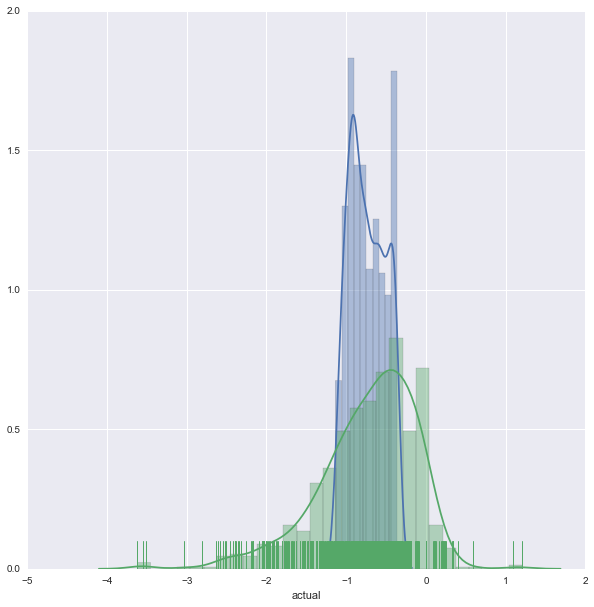

In [56]:
res = pred_vs_actual(clf, X, y)
print

In [75]:
cols = [col for col in X.columns if 'ALS' in col]
print X.loc[15154, cols]

family_ALS_hist_last       0.000000
ALSFRS_Total_mean          0.763436
ALSFRS_Total_pct_diff     -0.011771
ALSFRS_Total_last          0.563677
ALSFRS_Total_mean_slope    0.132226
Name: 15154, dtype: float64


Feature ranking:
1. feature onset_delta_last (0.570407)
2. feature fvc_percent_pct_diff (0.153219)
3. feature ALSFRS_Total_last (0.060527)
4. feature ALSFRS_Total_pct_diff (0.052920)
5. feature fvc_percent_last (0.032151)
6. feature weight_pct_diff (0.019011)
7. feature ALSFRS_Total_mean (0.017401)
8. feature mouth_mean (0.014232)
9. feature Red Blood Cells (RBC)_pct_diff (0.005374)
10. feature hands_mean (0.005191)


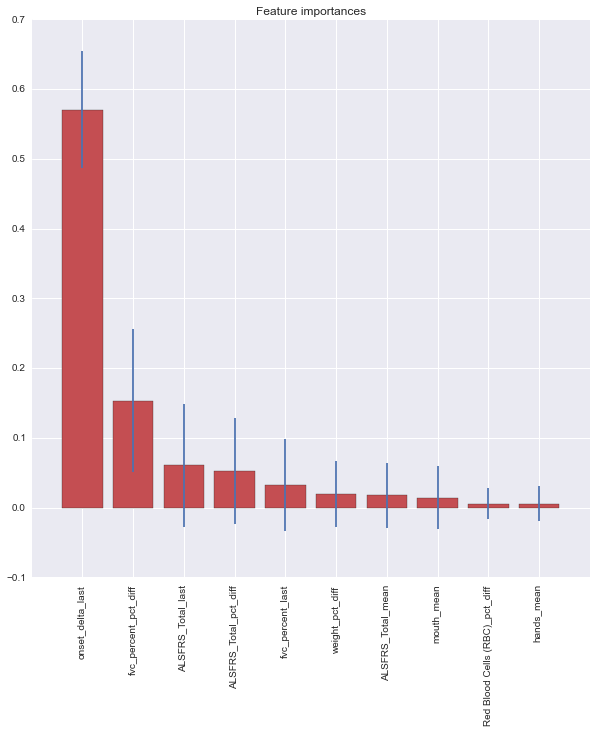

In [57]:
forest = clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), X.columns[indices], rotation='vertical')
plt.xlim([-1, 10])
plt.show()

In [83]:
q = np.percentile(forest.predict(X), range(20,100,20))
print q

[-0.95216928 -0.82328976 -0.66183843 -0.50351755]


In [84]:
clustering_model = {"model": forest, "bins": q}
pickle.dump( clustering_model, open('../forest_clustering_model.pickle', 'wb') )


In [85]:

for t in ['all', 'test']:
    cur_data = pd.read_csv('../' + t + '_data_vectorized.csv', sep = '|', error_bad_lines=False, index_col="SubjectID")
    res = pd.DataFrame(index = cur_data.index.astype(str)) # SubjectID is always str for later joins
    res['cluster'] = np.digitize(forest.predict(cur_data), q)
    print np.bincount(res.cluster)
    print t, res.shape
    res.to_csv('../' + t + '_forest_clusters.csv',sep='|')

[485 485 484 485 485]
all (2424, 1)
[109 128 122 119 122]
test (600, 1)
